### Solar Panel Placement Optimization Notebook 

We recommend to write your code in Python, so that your workflow can be seen using this notebook. However, feel free to use other languages and tools that you are comfortable with. 

Please generate images to illustrate how your algorithm works. 

Have fun! 

Run this cell first to define variables and import neccessary libraries

In [256]:
from shapely import Polygon, buffer, get_coordinates, bounds, covers, prepare
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as mplPolygon

# All numbers are in meters
testCoordinate1 = [(0, 0), (0, 100), (50, 0)]
testCoordinate2 = [(1.12, 130.83), (1.12, 160.83), (31.12, 160.83), (31.12, 130.83), (11.12, 100.83), (-11.12, 90.83), (-30.12, 90.83), (-20.182, 120.273)]
testCoordinate3 = [(2, 100), (2,160), (131, 160), (35, 200), (11, 300), (-20 , 90), (30, 90)]

COORDS = testCoordinate3
panelSizes = [(2,1),(2.3,1),(1.8,0.9)] # (width,heigh)
panelGap = 0.02
rowSpacing = 0.5


I'll start by getting the areas of the different rooftops - this will give us a benchmark of our layout's coverage. 
Formula for calculating area of shape using coordinates of vertices:

|((x1y2 - y1x2) + (x2y3 - y2x3) ... + (xny1 - ynx1)) / 2 |

In [257]:

def getRoofArea(polygon):
  # numerator = 0
  # for i in range(len(coords)):
  #   nextIndex = (i + 1) % len(coords)
  #   numerator += (coords[i][0] * coords[nextIndex][1]) - (coords[i][1] * coords[nextIndex][0])
  # area = abs(numerator / 2)
  # return area
  
  #* Scratch that, I found a library (shapely) that deals with geometric objects
  return polygon.area

# Helper Functions -

In [258]:
# returns an array [half of width, half of length] of given panel size.
def getOffsetDistance(panelSize):
  return [panelSize[0]/2, panelSize[1]/2]

# returns the area of 1 panel
def getPanelArea(panelSize):
  return panelSize[0] * panelSize[1]

Starting Point - a point within the roof geometry that a solar panel is guaranteed to fit inside. 

The function will offset the polygon inwards by half of the longest side of the chosen solar panel, and return the point on this offset curve with the smallest value of X and Y (bottom left)

In [259]:
# not used

def getStartingPoint(polygon, panelSize):
  offsetDistance = max(getOffsetDistance(panelSize)) * -1
  offsetPolygon = buffer(polygon, offsetDistance, cap_style="square", join_style="mitre")
  minX, minY, maxX, maxY = bounds(offsetPolygon)
  offsetCoordinates = get_coordinates(offsetPolygon).tolist()
  startingPoint = []
  
  for offsetCoord in offsetCoordinates:
    if offsetCoord[1] == minY:
      if not startingPoint:
        startingPoint = offsetCoord
      elif offsetCoord[0] < startingPoint[0]:
          startingPoint = offsetCoord
  
  return offsetCoordinates,startingPoint


# offset, startingPoint = getStartingPoint(testCoordinate3, panelSizes[0])
# print(startingPoint)

Alternatively, I could directly offset the minX, minY point and start my grid from there - this will be the method I implemented. 

Using the starting point and the offset bounding box as the bounds, I generate a grid of points which will be the <u>center points</u> of each individual solar panel.

This grid is merely an entire grid of points within the bounding box. I will use an additional function below to filter out the valid points where solar panels can be placed.

In [260]:
def getGrid(polygon, panelSize, shiftX = 0, shiftY = 0):
  offsetX, offsetY = getOffsetDistance(panelSize)
  
  minX, minY, maxX, maxY = bounds(polygon)

  def meterToMM(num):
    return int(1000 * num)
  
  def mmToMeter(num):
    return num/1000

  # redefine all variables in mm as to avoid errors in using float values
  startXmm = meterToMM(minX + offsetX)
  startYmm = meterToMM(minY + offsetY)
  maxXmm = meterToMM(maxX - offsetX)
  maxYmm = meterToMM(maxY - offsetY)
  shiftXmm = meterToMM(shiftX)
  shiftYmm = meterToMM(shiftY)
  rowSpacingmm = meterToMM(rowSpacing)
  panelGapmm = meterToMM(panelGap)
  panelXmm = meterToMM(panelSize[0])
  panelYmm = meterToMM(panelSize[1])
  
  grid = []
  
  for y in range(startYmm + shiftYmm, maxYmm, panelYmm + rowSpacingmm):
    for x in range(startXmm + shiftXmm, maxXmm, panelXmm + panelGapmm):
      # conversion back to Meters
      grid.append([mmToMeter(x) ,mmToMeter(y)])
    
  return grid

This function will take each point in the grid and extrapolate the 4 corner points of the solar panel, then check if all corners are "contained" within the roof polygon. If yes, then this is a valid solar panel placement.

In [261]:
def panelsOnRoof(polygon, grid, panelSize):
  validGrid = []
  offsetX, offsetY = getOffsetDistance(panelSize)
  for point in grid:
    x,y = point
    minusX = x - offsetX
    addX = x + offsetX
    minusY = y - offsetY
    addY = y + offsetY
    
    topLeft = (minusX, addY)
    topRight = (addX, addY)
    bottomLeft = (minusX, minusY)
    bottomRight = (addX, minusY)
    
    panelCoords = [topLeft, topRight,bottomRight,bottomLeft]
    panelPolygon = Polygon(panelCoords)
    
    if covers(polygon,panelPolygon):
      validGrid.append(panelCoords)
    
  return validGrid 

Create a function to visualise the rooftop shapes using matplotlib

In [262]:
def visualiseRooftop(roofCoords, panelGrid):
  x = []
  y = []
  fig, ax = plt.subplots()

  for coord in roofCoords:
    # plt.plot(coord[0], coord[1], marker = "o")
    x.append(coord[0])
    y.append(coord[1])
    
  x.append(roofCoords[0][0])
  y.append(roofCoords[0][1])

  ax.plot(x,y, color="black")
  ax.fill(x,y, color="lightgrey")

  for panelCorners in panelGrid:
    panelPolygon = mplPolygon(panelCorners, closed=True, facecolor="mediumblue")
    ax.add_patch(panelPolygon)
    # plt.plot(panel[0],panel[1], marker = "s")
    
  ax.autoscale()
  ax.set_aspect("equal", "box")
  plt.show()
  
  return

## Algorithm discussion
During my [M.Arch thesis](https://www.ar-dan.com/what-the-farm), I used Rhino and Grasshopper to run simulations on building rooftops and facades - the general idea was to see if any slight rotations in buildings could lead to significantly more sunlight for vertical farming. The program used an evolutionary algorithm to return the ideal configuration.

Doing something similar was my first thought when I saw the assignment, but thinking deeper about it, I don't think its the correct path to go down. The key differences was that the daylight simulations I had previously used were very computationally intensive, taking 3-5min per simulation, and I had about 5 buildings to rotate. Using an evolutionary algorithm meant that I didn't need to test all possible permutations, but could narrow down quickly and reduce computation time. Perhaps this is something that could be explored further in the future.

Additionally, since one of the assignment's objective is to assess the quality of my thought process, I will work to develop my algorithm rather than just plugging the data into an already developed algorithm.

My first instinct was that I should start without rotation, and just differing panel sizes. However, after more time spent thinking about the problem, my hypothesis (and what I will build my algorithm off) is that:
- The **rotation will actually have the largest impact on coverage** (may not apply to all cases, will discuss my assumptions later). 
- Choose the best rotation (perhaps include more rotation values if the preliminary results are close)
- Test panel sizes and shifting

### Rotation
There are 2 main optimisations that I think will significantly reduce the computational requirements.
- Instead of rotating the solar panels itself (which will make keeping the aligned rows and columns difficult), we can simply <u>rotate the roof</u> to achieve the same result. Thus, the solar panels will always be aligned orthogonally. 
- Instead of testing rotation based on a fixed "step" (e.g testing in increments of 5 degrees), my instinct tells me that the best orientations would be when at least <u>1 edge is at 0 degrees</u>. 

Using trigonometry, I can calculate the angle of the edge with the coordinates of adjacent vertices. It is important to include the normal (90 degree) rotation as well, to account for the 2 possible orientations of the solar panel itself.



In [263]:
import math

def getEdgeAngles(roofCoords):
  angles = set()
  for i in range(len(roofCoords)):
    currPoint = roofCoords[i]
    nextPoint = roofCoords[(i + 1) % len(roofCoords)]
    
    # calculate the angle using arc tangent (opposite/adjacent)
    height = nextPoint[1] - currPoint[1]
    length = nextPoint[0] - currPoint[0]
    angle = math.degrees(math.atan2(height,length))
    
    # check if opposite of angle is already in the set (no point checking both 30 degrees and 210 degrees (180 + 30))
    if angle >= 180:
      if angle - 180 not in angles:
        angles.add(angle)
        angles.add((angle + 90) % 180)
    else:
      angles.add(angle)
      angles.add((angle + 90) % 180)
      
  return list(angles)

[0.0, 160.3461759419467, 67.38013505195957, 70.34617594194671, 103.49573328079582, 171.60269741331024, 13.495733280795832, 90.0, 157.38013505195957, -98.39730258668975]
Roof Area: 6845.0
2070


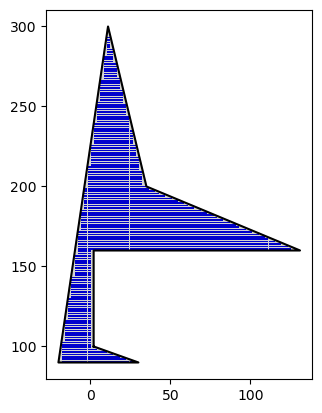

In [264]:
def main():
  roofPolygon = Polygon(COORDS)
  
  # preparing will reduce computational load for complex roof shapes
  prepare(roofPolygon)
  
  #get roof angles
  angles = getEdgeAngles(COORDS)
  print(angles)
  roofArea = getRoofArea(roofPolygon)
  print("Roof Area:", roofArea)
  
  gridOfCenters = getGrid(roofPolygon, panelSizes[0])
  gridOfValidPanels = panelsOnRoof(roofPolygon,gridOfCenters, panelSizes[0])
  print(len(gridOfValidPanels))
  visualiseRooftop(COORDS, gridOfValidPanels)
  
main()